<a href="https://colab.research.google.com/github/Rohit-Chatterjee08/rcworld/blob/main/Introduction_to_Semantic_Segmentation_using_TensorFlow_Hub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import cv2
import glob as glob

import tensorflow as tf
import tensorflow_hub as hub

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from zipfile import ZipFile
from urllib.request import urlretrieve

import warnings
import logging
import absl

# Filter absl warnings
warnings.filterwarnings("ignore", module="absl")

# Capture all warnings in the logging system
logging.captureWarnings(True)

# Set the absl logger level to 'error' to suppress warnings
absl_logger = logging.getLogger("absl")
absl_logger.setLevel(logging.ERROR)

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

In [2]:
def download_and_unzip(url, save_path):
    print(f"Downloading and extracting assests....", end="")

    # Downloading zip file using urllib package.
    urlretrieve(url, save_path)

    try:
        # Extracting zip file using the zipfile package.
        with ZipFile(save_path) as z:
            # Extract ZIP file contents in the same directory.
            z.extractall(os.path.split(save_path)[0])

        print("Done")

    except Exception as e:
        print("\nInvalid file.", e)

In [3]:
URL = r"https://www.dropbox.com/s/wad5js22fbeo1be/camvid_images.zip?dl=1"

asset_zip_path = os.path.join(os.getcwd(), "camvid_images.zip")

# Download if assest ZIP does not exists.
if not os.path.exists(asset_zip_path):
    download_and_unzip(URL, asset_zip_path)

In [4]:
image_paths = sorted(glob.glob("camvid_images" + os.sep + "*.png"))

for idx in range(len(image_paths)):
    print(image_paths[idx])

camvid_images/camvid_sample_1.png
camvid_images/camvid_sample_2.png
camvid_images/camvid_sample_3.png
camvid_images/camvid_sample_4.png


In [5]:
def load_image(path):
    image = cv2.imread(path)

    # Convert image in BGR format to RGB.
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Add a batch dimension which is required by the model.
    image = np.expand_dims(image, axis=0) / 255.0

    return image

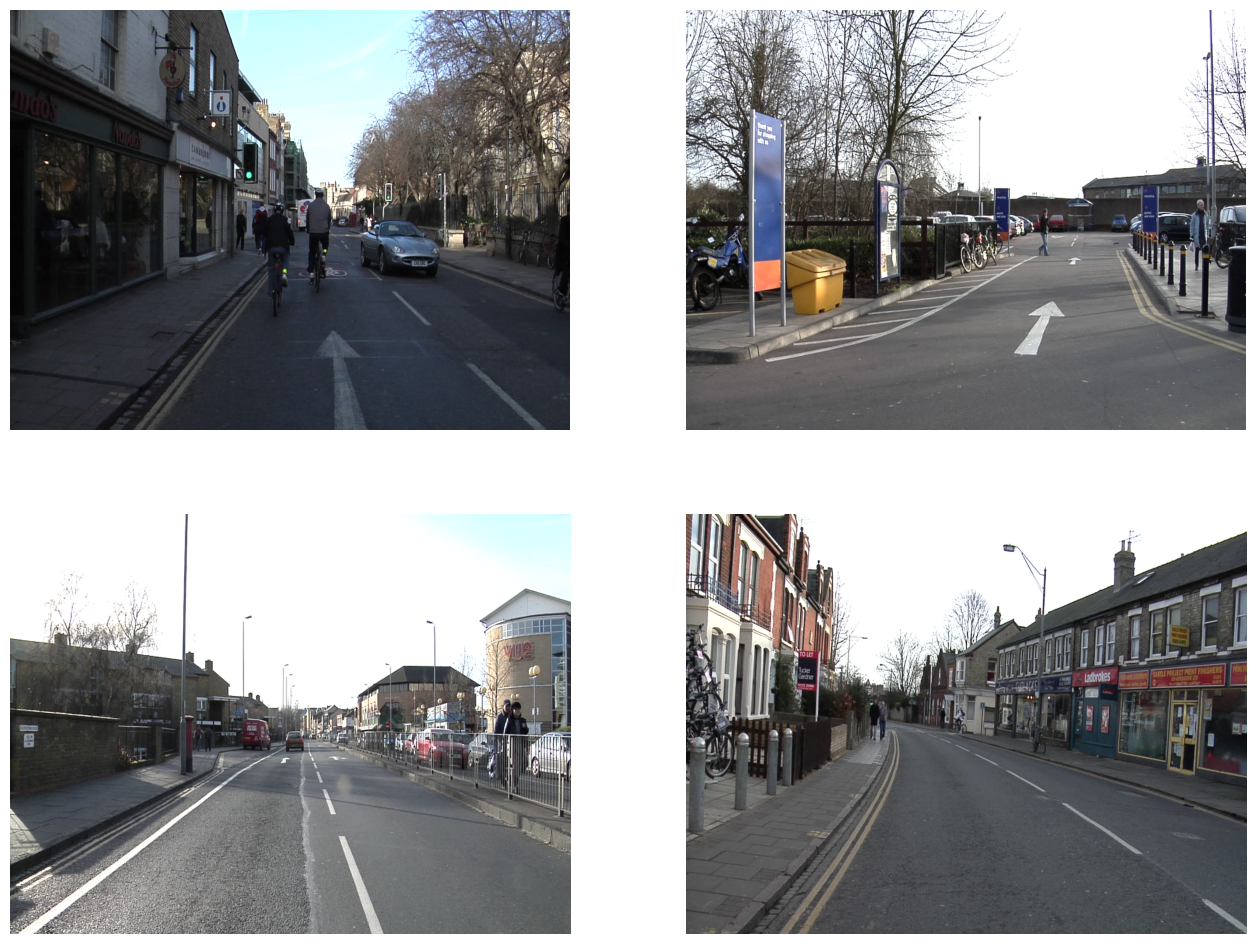

In [6]:
images = []
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))

for idx, axis in enumerate(ax.flat):
    image = load_image(image_paths[idx])
    images.append(image)
    axis.imshow(image[0])
    axis.axis("off")

In [7]:
class_index = \
    {
         0: [(64, 128, 64),  'Animal'],
         1: [(192, 0, 128),  'Archway'],
         2: [(0, 128, 192),  'Bicyclist'],
         3: [(0, 128, 64),   'Bridge'],
         4: [(128, 0, 0),    'Building'],
         5: [(64, 0, 128),   'Car'],
         6: [(64, 0, 192),   'Cart/Luggage/Pram'],
         7: [(192, 128, 64), 'Child'],
         8: [(192, 192, 128),'Column Pole'],
         9: [(64, 64, 128),  'Fence'],
        10: [(128, 0, 192),  'LaneMkgs Driv'],
        11: [(192, 0, 64),   'LaneMkgs NonDriv'],
        12: [(128, 128, 64), 'Misc Text'],
        13: [(192, 0, 192),  'Motorcycle/Scooter'],
        14: [(128, 64, 64),  'Other Moving'],
        15: [(64, 192, 128), 'Parking Block'],
        16: [(64, 64, 0),    'Pedestrian'],
        17: [(128, 64, 128), 'Road'],
        18: [(128, 128, 192),'Road Shoulder'],
        19: [(0, 0, 192),    'Sidewalk'],
        20: [(192, 128, 128),'Sign Symbol'],
        21: [(128, 128, 128),'Sky'],
        22: [(64, 128, 192), 'SUV/Pickup/Truck'],
        23: [(0, 0, 64),     'Traffic Cone'],
        24: [(0, 64, 64),    'Traffic Light'],
        25: [(192, 64, 128), 'Train'],
        26: [(128, 128, 0),  'Tree'],
        27: [(192, 128, 192),'Truck/Bus'],
        28: [(64, 0, 64),    'Tunnel'],
        29: [(192, 192, 0),  'Vegetation Misc'],
        30: [(0, 0, 0),      'Void'],
        31: [(64, 192, 0),   'Wall']
    }

In [8]:
model_url = "https://tfhub.dev/google/HRNet/camvid-hrnetv2-w48/1"
print("loading model:", model_url)

seg_model = hub.load(model_url)
print("\nmodel loaded!")

loading model: https://tfhub.dev/google/HRNet/camvid-hrnetv2-w48/1

model loaded!


In [9]:
# Make a prediction using the first image in the list of images.
pred_mask = seg_model.predict(images[0])

# The predicted mask has the following shape: [B, H, W, C].
print("Shape of predicted mask:", pred_mask.shape)

Shape of predicted mask: (1, 720, 960, 33)


In [10]:
# Convert tensor to numpy array.
pred_mask = pred_mask.numpy()

# The 1st label is the background class added by the model, but we can remove it for this dataset.
pred_mask = pred_mask[:, :, :, 1:]

# We also need to remove the batch dimension.
pred_mask = np.squeeze(pred_mask)

# Print the shape to confirm: [H, W, C].
print("Shape of predicted mask after removal of batch dimension and background class:", pred_mask.shape)

Shape of predicted mask after removal of batch dimension and background class: (720, 960, 32)


(np.float64(-0.5), np.float64(959.5), np.float64(719.5), np.float64(-0.5))

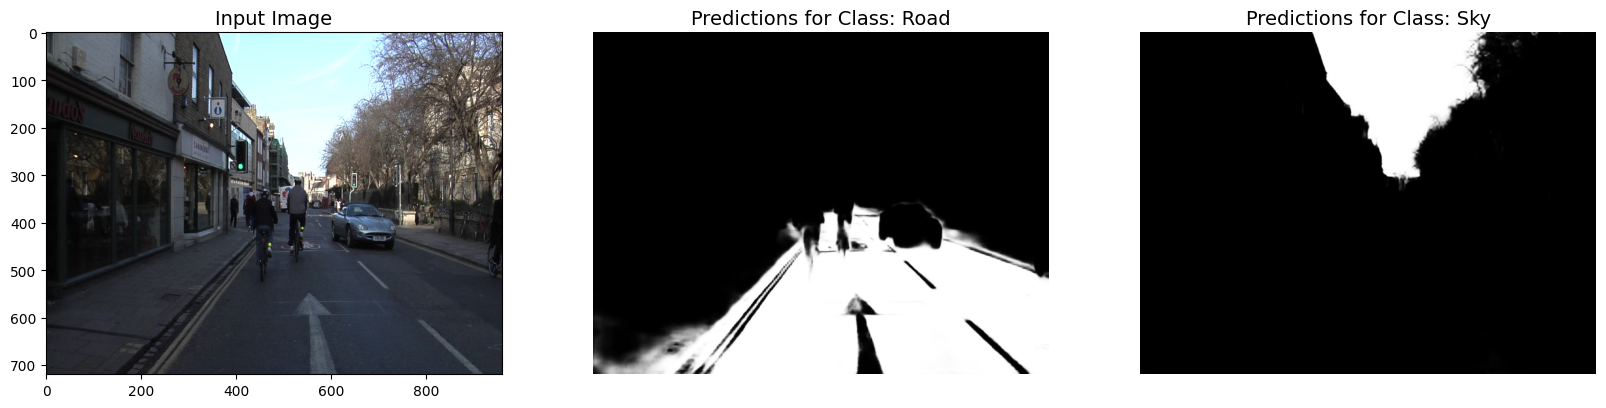

In [11]:
# Each channel in `pred_mask` contains the probabilities that the pixels
# in the original image are associated with the class for that channel.
plt.figure(figsize=(20, 6))

plt.subplot(1, 3, 1)
plt.title("Input Image", fontsize=14)
plt.imshow(np.squeeze(images[0]))

plt.subplot(1, 3, 2)
plt.title("Predictions for Class: Road", fontsize=14)
plt.imshow(pred_mask[:, :, 17], cmap="gray") # Class 17 corresponds to the 'road' class
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Predictions for Class: Sky", fontsize=14)
plt.imshow(pred_mask[:, :, 21], cmap="gray") # Class 21 corresponds to the 'sky' class
plt.axis("off")

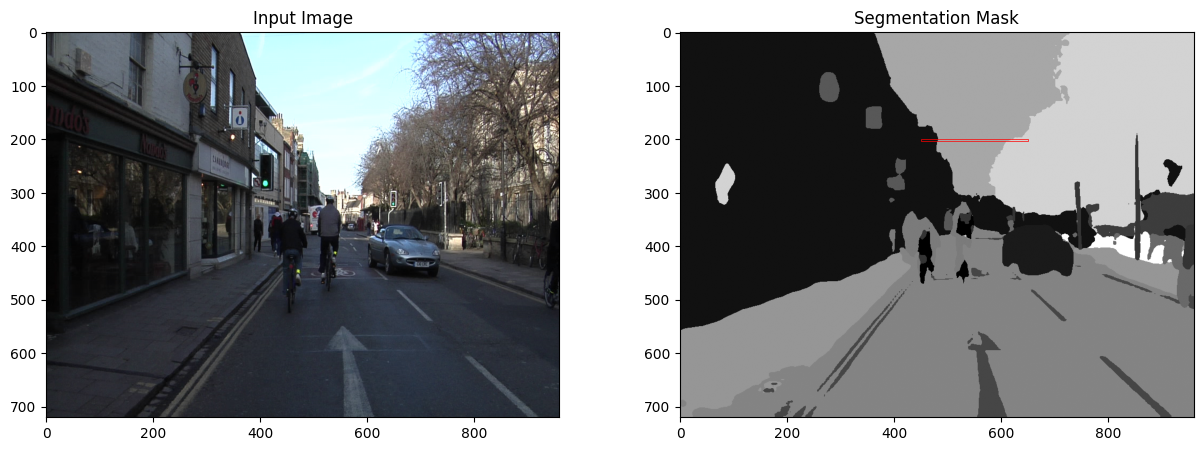

In [12]:
# Assign each pixel in the image a class ID based on the channel that contains the
# highest probability score. This can be implemented using the `argmax` function.
pred_mask_class = np.argmax(pred_mask, axis=-1)

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title("Input Image", fontsize=12)
plt.imshow(np.squeeze(images[0]))

plt.subplot(1, 2, 2)
plt.title("Segmentation Mask", fontsize=12)
plt.imshow(pred_mask_class, cmap="gray")
plt.gca().add_patch(Rectangle((450, 200), 200, 3, edgecolor="red", facecolor="none", lw=0.5))

In [13]:
# Print the class IDs from the last row in the above image.
print(pred_mask_class[200, 450:650])

[ 4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21
 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21
 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21
 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21
 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21
 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21
 26 26 21 21 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26
 26 26 26 26 26 26 26 26]


In [14]:
# Function to convert a single channel mask representation to an RGB mask.
def class_to_rgb(mask_class, class_index):

    # Create RGB channels.
    r_map = np.zeros_like(mask_class).astype(np.uint8)
    g_map = np.zeros_like(mask_class).astype(np.uint8)
    b_map = np.zeros_like(mask_class).astype(np.uint8)

    # Populate RGB color channels based on the color assigned to each class.
    for class_id in range(len(class_index)):
        index = mask_class == class_id
        r_map[index] = class_index[class_id][0][0]
        g_map[index] = class_index[class_id][0][1]
        b_map[index] = class_index[class_id][0][2]

    seg_map_rgb = np.stack([r_map, g_map, b_map], axis=2)

    return seg_map_rgb

(np.float64(-0.5), np.float64(959.5), np.float64(719.5), np.float64(-0.5))

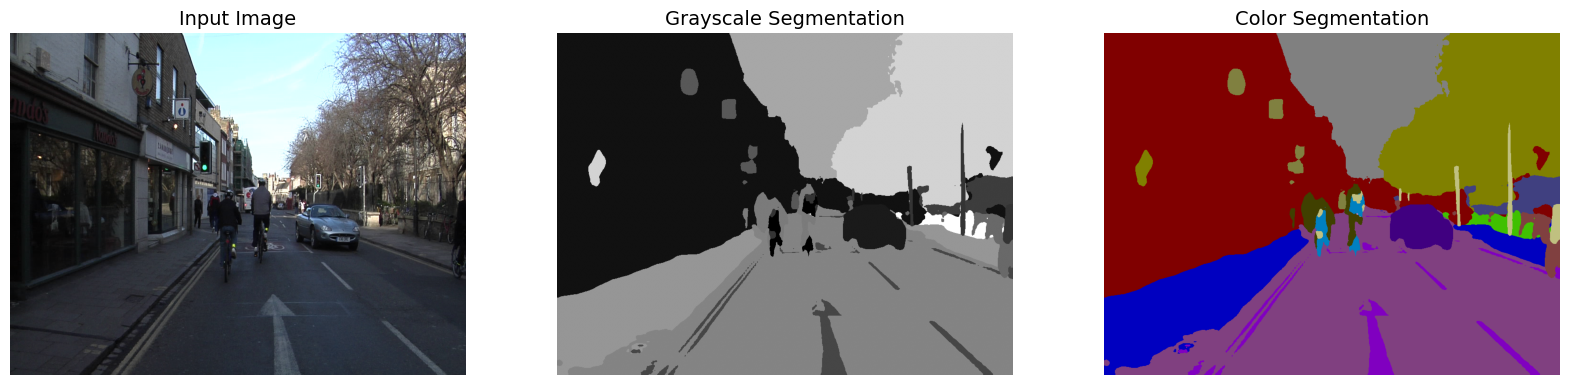

In [15]:
pred_mask_rgb = class_to_rgb(pred_mask_class, class_index)

plt.figure(figsize=(20, 8))

plt.subplot(1, 3, 1)
plt.title("Input Image", fontsize=14)
plt.imshow(np.squeeze(images[0]))
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Grayscale Segmentation", fontsize=14)
plt.imshow(pred_mask_class, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Color Segmentation", fontsize=14)
plt.imshow(pred_mask_rgb, cmap="gray")
plt.axis("off")

In [16]:
# Function to overlay a segmentation map on top of an RGB image.
def image_overlay(image, seg_map_rgb):

    alpha = 1.0  # Transparency for the original image.
    beta  = 0.6  # Transparency for the segmentation map.
    gamma = 0.0  # Scalar added to each sum.

    image = (image * 255.0).astype(np.uint8)
    seg_map_rgb = cv2.cvtColor(seg_map_rgb, cv2.COLOR_RGB2BGR)

    image = cv2.addWeighted(image, alpha, seg_map_rgb, beta, gamma)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    return image

In [17]:
def run_inference(images, model):
    for img in images:
        # Forward pass through the model (convert the tensor output to a numpy array).
        pred_mask = model.predict(img).numpy()

        # Remove the background class added by the model.
        pred_mask = pred_mask[:, :, :, 1:]

        # Remove the batch dimension.
        pred_mask = np.squeeze(pred_mask)

        # `pred_mask` is a numpy array of shape [H, W, 32] where each channel contains the probability
        # scores associated with a given class. We still need to assign a single class to each pixel
        # which is accomplished using the argmax function across the last dimension to obtain the class labels.
        pred_mask_class = np.argmax(pred_mask, axis=-1)

        # Convert the predicted (class) segmentation map to a color segmentation map.
        pred_mask_rgb = class_to_rgb(pred_mask_class, class_index)

        fig = plt.figure(figsize=(20, 15))

        # Display the original image.
        ax1 = fig.add_subplot(1, 3, 1)
        ax1.imshow(img[0])
        ax1.title.set_text("Input Image")
        plt.axis("off")

        # Display the predicted color segmentation mask.
        ax2 = fig.add_subplot(1, 3, 2)
        ax2.set_title("Predicted Mask")
        ax2.imshow(pred_mask_rgb)
        plt.axis("off")

        # Display the predicted color segmentation mask overlayed on the original image.
        overlayed_image = image_overlay(img[0], pred_mask_rgb)
        ax4 = fig.add_subplot(1, 3, 3)
        ax4.set_title("Overlayed Image")
        ax4.imshow(overlayed_image)
        plt.axis("off")

        plt.show()

In [18]:
def plot_color_legend(class_index):
    # Extract colors and labels from class_index dictionary.
    color_array = np.array([[v[0][0], v[0][1], v[0][2]] for v in class_index.values()]).astype(np.uint8)
    class_labels = [val[1] for val in class_index.values()]

    fig, ax = plt.subplots(nrows=2, ncols=16, figsize=(20, 3))
    plt.subplots_adjust(wspace=0.5, hspace=0.01)

    # Display color legend.
    for i, axis in enumerate(ax.flat):
        axis.imshow(color_array[i][None, None, :])
        axis.set_title(class_labels[i], fontsize=8)
        axis.axis("off")

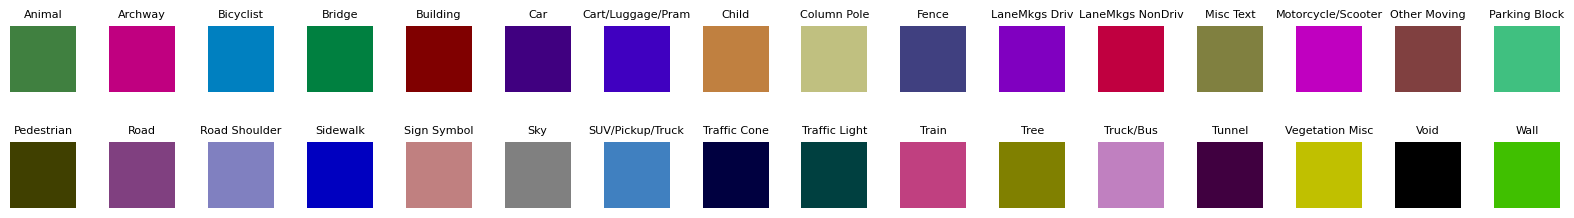

In [19]:
plot_color_legend(class_index)

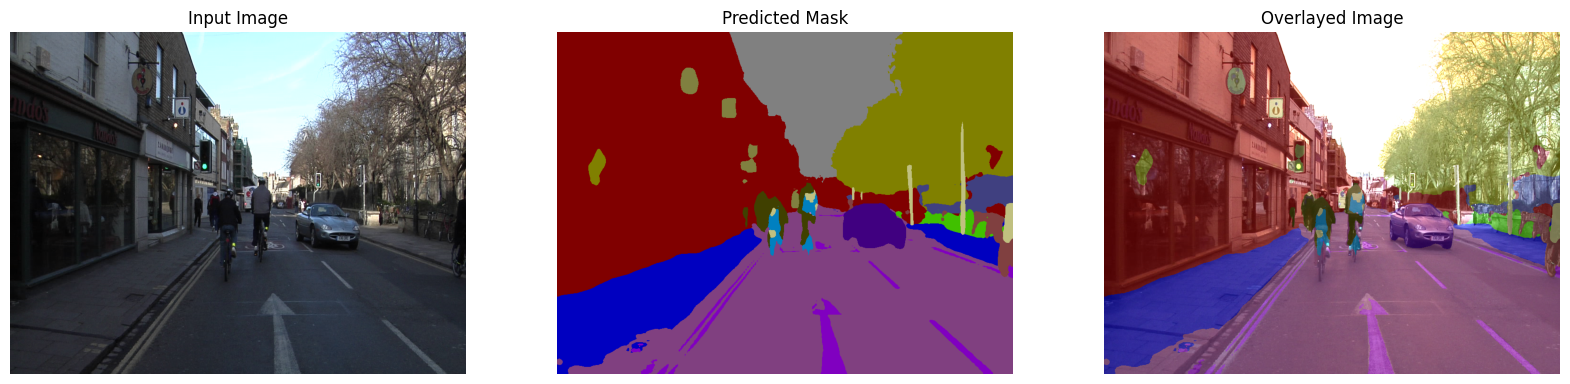

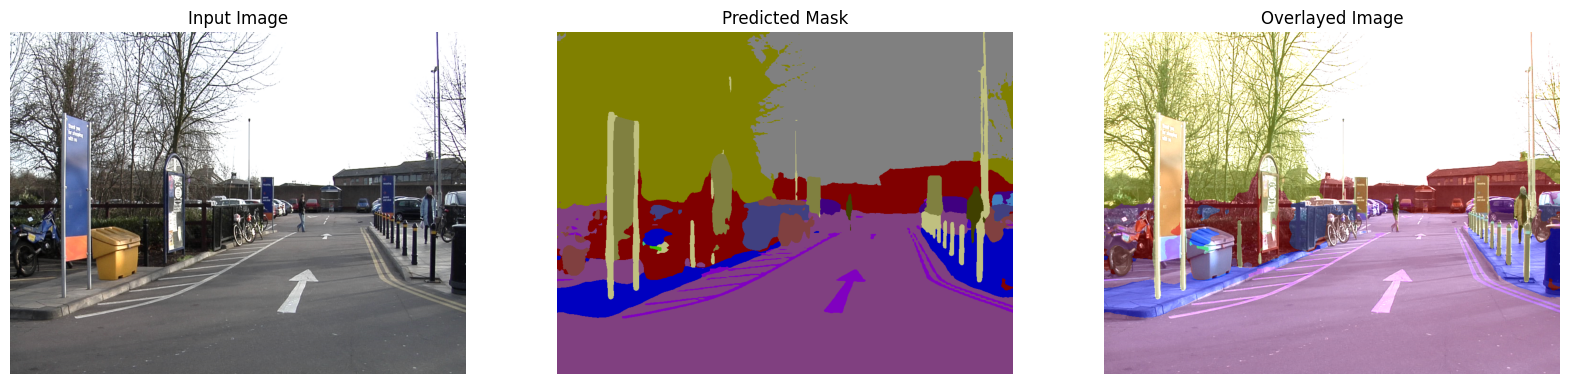

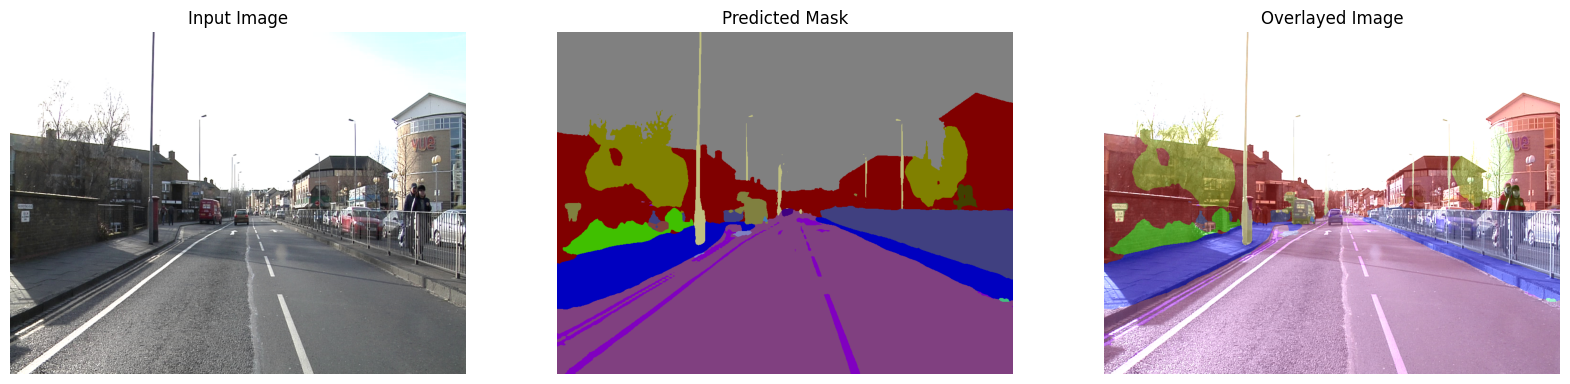

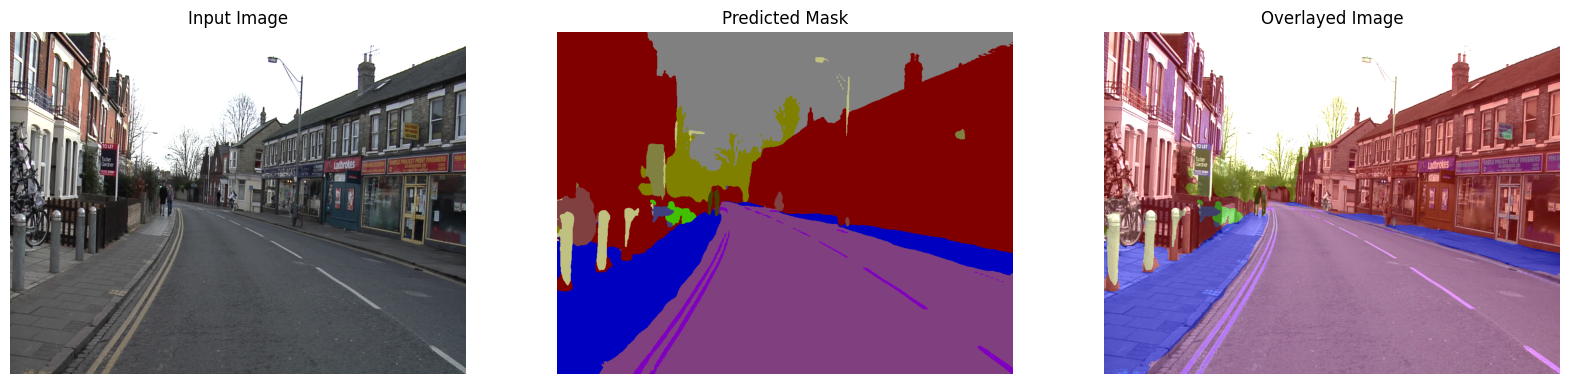

In [20]:
run_inference(images, seg_model)